In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings

# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2

import gc
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn import decomposition, manifold, cluster, metrics


#

# hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt

#autres librairies
import missingno as msno

In [3]:
# Specify the correct path to your CSV file in Google Drive
csv_path ='/content/drive/MyDrive/openclass/df_new.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
3,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
4,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,4
...,...,...,...
705,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
706,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
707,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
708,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [4]:
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

# Liste des fichiers présents dans le répertoire des images
image_directory = '/content/drive/MyDrive/openclass/images'
image_files = os.listdir(image_directory)
image_files_set = set(image_files)

# Vérifiez l'unicité des noms de fichiers dans le DataFrame
unique_images = df['image'].unique()
print(f"Unique images in DataFrame: {len(unique_images)}")

# Filtrez les images qui existent dans le répertoire
df['image_exists'] = df['image'].apply(lambda x: x in image_files_set)
df_filtered = df[df['image_exists']]

# Mettez à jour le chemin de l'image après filtrage
df_filtered['image_path'] = df_filtered['image'].apply(lambda x: os.path.join(image_directory, x))

# Affichez quelques lignes pour vérifier
print("First 5 filtered image paths:", df_filtered['image_path'].head())

# Si vous voulez, supprimez la colonne 'image_exists' maintenant inutile
df_filtered.drop(columns=['image_exists'], inplace=True)

# Continuez avec le DataFrame filtré
df = df_filtered

# Encode labels
le = preprocessing.LabelEncoder()
le.fit(df["label_name"])
df["label"] = le.transform(df["label_name"])


Unique images in DataFrame: 710
First 5 filtered image paths: 0     /content/drive/MyDrive/openclass/images/55b85e...
3     /content/drive/MyDrive/openclass/images/6325b6...
7     /content/drive/MyDrive/openclass/images/f0938b...
10    /content/drive/MyDrive/openclass/images/66191b...
13    /content/drive/MyDrive/openclass/images/532521...
Name: image_path, dtype: object


In [5]:
import os
import numpy as np
import pandas as pd
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Configuration
image_size = (224, 224)
batch_size = 32
num_classes = len(df["label"].unique())

# Création des générateurs de données avec Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='image_path',
    y_col='label_name',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='image_path',
    y_col='label_name',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Chargement du modèle ResNet50 pré-entraîné sur ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajout de nouvelles couches pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_los-=s', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Évaluation du modèle
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


Found 272 validated image filenames belonging to 7 classes.
Found 68 validated image filenames belonging to 7 classes.
94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 2.1631 - accuracy: 0.2167

8/8 [==============================] - 91s 11s/step - loss: 2.1631 - accuracy: 0.2167 - val_loss: 1.9308 - val_accuracy: 0.2188
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.8298 - accuracy: 0.3008

8/8 [==============================] - 95s 12s/step - loss: 1.8298 - accuracy: 0.3008 - val_loss: 1.8703 - val_accuracy: 0.2969
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.8003 - accuracy: 0.2917

8/8 [==============================] - 89s 11s/step - loss: 1.8003 - accuracy: 0.2917 - val_loss: 2.0976 - val_accuracy: 0.1406
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.7241 - accuracy: 0.3583

8/8 [==============================] - 84s 10s/step - loss: 1.7241 - accuracy: 0.3583 - val_loss: 1.9531 - val_accuracy: 0.2500
Epoch 5/50
8/8 [==============================] - ETA: 0s - loss: 1.6943 - accuracy: 0.3164

8/8 [==============================] - 96s 12s/step - loss: 1.6943 - accuracy: 0.3164 - val_loss: 1.9998 - val_accuracy: 0.1562
Epoch 6/50
8/8 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3500

8/8 [==============================] - 86s 11s/step - loss: 1.6766 - accuracy: 0.3500 - val_loss: 1.8145 - val_accuracy: 0.1562
Epoch 7/50
8/8 [==============================] - ETA: 0s - loss: 1.6577 - accuracy: 0.3292

8/8 [==============================] - 92s 12s/step - loss: 1.6577 - accuracy: 0.3292 - val_loss: 2.2338 - val_accuracy: 0.1875
Epoch 8/50
8/8 [==============================] - ETA: 0s - loss: 1.5938 - accuracy: 0.3542 

8/8 [==============================] - 134s 17s/step - loss: 1.5938 - accuracy: 0.3542 - val_loss: 1.7897 - val_accuracy: 0.3438
Epoch 9/50
8/8 [==============================] - ETA: 0s - loss: 1.5855 - accuracy: 0.3708

8/8 [==============================] - 101s 12s/step - loss: 1.5855 - accuracy: 0.3708 - val_loss: 2.0556 - val_accuracy: 0.2031
Epoch 10/50
8/8 [==============================] - ETA: 0s - loss: 1.6823 - accuracy: 0.3203

8/8 [==============================] - 89s 11s/step - loss: 1.6823 - accuracy: 0.3203 - val_loss: 2.0458 - val_accuracy: 0.1875
Epoch 11/50
8/8 [==============================] - ETA: 0s - loss: 1.5610 - accuracy: 0.3917

8/8 [==============================] - 87s 11s/step - loss: 1.5610 - accuracy: 0.3917 - val_loss: 2.1146 - val_accuracy: 0.1719
Epoch 12/50
8/8 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.3625

8/8 [==============================] - 85s 11s/step - loss: 1.6014 - accuracy: 0.3625 - val_loss: 1.6451 - val_accuracy: 0.4375
Epoch 13/50
8/8 [==============================] - ETA: 0s - loss: 1.6240 - accuracy: 0.3500

8/8 [==============================] - 95s 13s/step - loss: 1.6240 - accuracy: 0.3500 - val_loss: 2.0891 - val_accuracy: 0.2344
Epoch 14/50
8/8 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.4167 

8/8 [==============================] - 110s 14s/step - loss: 1.6239 - accuracy: 0.4167 - val_loss: 2.0664 - val_accuracy: 0.1094
Epoch 15/50
8/8 [==============================] - ETA: 0s - loss: 1.6176 - accuracy: 0.3500

8/8 [==============================] - 87s 11s/step - loss: 1.6176 - accuracy: 0.3500 - val_loss: 2.0584 - val_accuracy: 0.3750
Epoch 16/50
8/8 [==============================] - ETA: 0s - loss: 1.5923 - accuracy: 0.3667

8/8 [==============================] - 88s 11s/step - loss: 1.5923 - accuracy: 0.3667 - val_loss: 1.9208 - val_accuracy: 0.2031
Epoch 17/50
8/8 [==============================] - ETA: 0s - loss: 1.5700 - accuracy: 0.3958

8/8 [==============================] - 82s 10s/step - loss: 1.5700 - accuracy: 0.3958 - val_loss: 2.1323 - val_accuracy: 0.1719
Epoch 18/50
8/8 [==============================] - ETA: 0s - loss: 1.5062 - accuracy: 0.4208

8/8 [==============================] - 86s 11s/step - loss: 1.5062 - accuracy: 0.4208 - val_loss: 1.7624 - val_accuracy: 0.4531
Epoch 19/50
8/8 [==============================] - ETA: 0s - loss: 1.5990 - accuracy: 0.3250

8/8 [==============================] - 88s 11s/step - loss: 1.5990 - accuracy: 0.3250 - val_loss: 2.0104 - val_accuracy: 0.1562
Epoch 20/50
8/8 [==============================] - ETA: 0s - loss: 1.5047 - accuracy: 0.3750

8/8 [==============================] - 87s 11s/step - loss: 1.5047 - accuracy: 0.3750 - val_loss: 2.0660 - val_accuracy: 0.2812
Epoch 21/50
8/8 [==============================] - ETA: 0s - loss: 1.4946 - accuracy: 0.3984

8/8 [==============================] - 89s 11s/step - loss: 1.4946 - accuracy: 0.3984 - val_loss: 1.8455 - val_accuracy: 0.2656
Epoch 22/50
8/8 [==============================] - ETA: 0s - loss: 1.4792 - accuracy: 0.4417

3/3 [==============================] - 17s 3s/step - loss: 1.7156 - accuracy: 0.4118
Validation loss: 1.7155555486679077
Validation accuracy: 0.4117647111415863


102967424/102967424 [==============================] - 1s 0us/step
Processing image 0/340
Processing image 100/340
Processing image 200/340
Processing image 300/340
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 340 samples in 0.002s...
[t-SNE] Computed neighbors for 340 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 340 / 340
[t-SNE] Mean sigma: 14.576475
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.944668
[t-SNE] KL divergence after 300 iterations: 0.823468
ARI: 0.3075850270985348


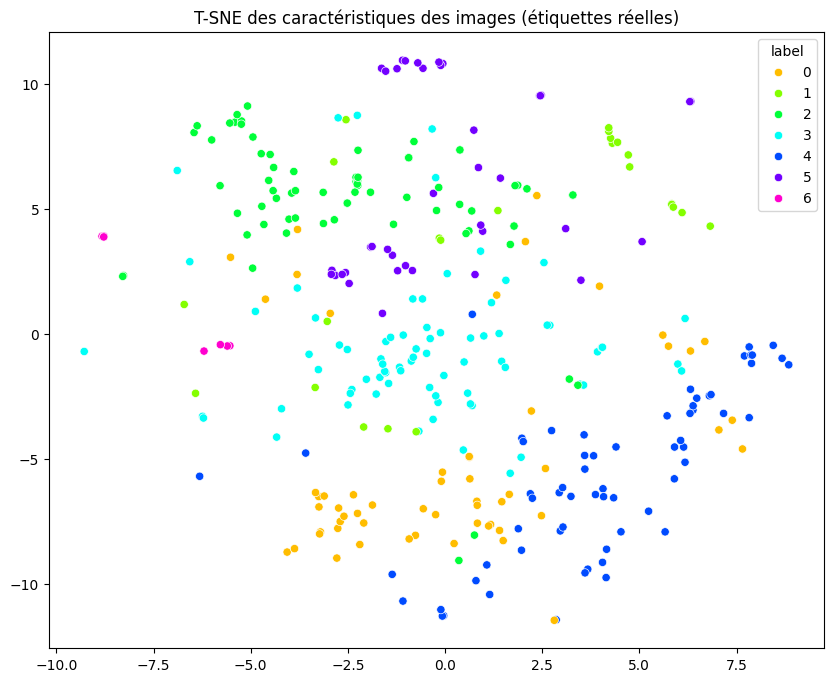

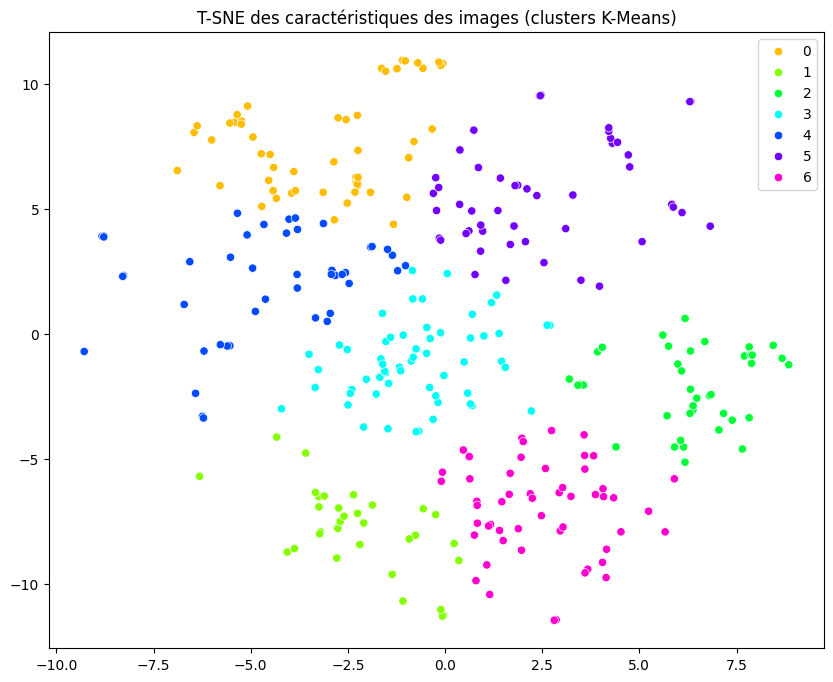

In [6]:

import os
import numpy as np
import pandas as pd
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le modèle ResNet50 pré-entraîné sur ImageNet
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Fonction pour extraire les caractéristiques des images
def extract_features(image_path, model):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image, verbose=0)
    return features.flatten()

# Extraction des caractéristiques en utilisant ResNet50
features = []
for i, image_path in enumerate(df['image_path']):
    if i % 100 == 0:
        print(f'Processing image {i}/{len(df)}')
    feature = extract_features(image_path, model)
    features.append(feature)

features = np.array(features)

# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(features)

# Clustering avec K-Means
num_classes = len(df["label"].unique())
kmeans = KMeans(n_clusters=num_classes)
kmeans_labels = kmeans.fit_predict(tsne_result)

# Calcul de l'ARI
ari = adjusted_rand_score(df["label"], kmeans_labels)
print(f'ARI: {ari}')

# Visualisation T-SNE selon les étiquettes réelles
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=df["label"], palette=sns.color_palette("hsv", num_classes))
plt.title('T-SNE des caractéristiques des images (étiquettes réelles)')
plt.show()

# Visualisation T-SNE selon les clusters K-Means
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=kmeans_labels, palette=sns.color_palette("hsv", num_classes))
plt.title('T-SNE des caractéristiques des images (clusters K-Means)')
plt.show()


In [7]:
df

,image,label_name,label,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,/content/drive/MyDrive/openclass/images/55b85e...
3,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,/content/drive/MyDrive/openclass/images/6325b6...
7,f0938b0d88eac91deee6d5add54097d3.jpg,Home Decor & Festive Needs,3,/content/drive/MyDrive/openclass/images/f0938b...
10,66191b4a311b5d9babfc00a71ef97c5b.jpg,Home Furnishing,4,/content/drive/MyDrive/openclass/images/66191b...
13,5325213d84c80ad310b6e4b37a1ac824.jpg,Baby Care,0,/content/drive/MyDrive/openclass/images/532521...
...,...,...,...,...
700,3b465b02720ef7c930cb2e065a8fc05d.jpg,Baby Care,0,/content/drive/MyDrive/openclass/images/3b465b...
702,057836ecde71565f8ebdd576e41fdc96.jpg,Baby Care,0,/content/drive/MyDrive/openclass/images/057836...
703,38782cce965307ddcdbedfcb7fa409c3.jpg,Baby Care,0,/content/drive/MyDrive/openclass/images/38782c...
706,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,/content/drive/MyDrive/openclass/images/fd6cbc...


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images_by_label(df, label_name):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), gridspec_kw={'wspace': 0.1})
    fig.suptitle(f'Exemples d\'images pour la classe "{label_name}"', fontsize=14)

    images_to_show = df[df['label_name'] == label_name]['image_path'].sample(5).values

    for i, image_path in enumerate(images_to_show):
        ax = axes[i]
        ax.imshow(mpimg.imread(image_path))
        ax.axis('off')
        ax.set_title(f'Image {i+1}')

    plt.show()


In [14]:
unique_labels = df['label_name'].unique()

for label_name in unique_labels:
    show_images_by_label(df, label_name)


Output hidden; open in https://colab.research.google.com to view.

In [17]:
def show_images_by_label(df, label_name, kmeans_labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3), gridspec_kw={'wspace': 0.1})
    fig.suptitle(f'Exemples d\'images pour la classe "{label_name}"', fontsize=14)

    # Sélection des indices d'images correspondant à l'étiquette réelle et prédite par K-Means
    indices = df[(df['label'] == label_name) & (kmeans_labels == df['label'])].index

    if len(indices) < num_samples:
        raise ValueError(f"Not enough samples for label '{label_name}' and predicted K-Means label.")

    # Choix aléatoire d'échantillons à afficher
    sample_indices = np.random.choice(indices, size=num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        ax.imshow(mpimg.imread(df.loc[idx, 'image_path']))
        ax.axis('off')
        ax.set_title(f'Image {i+1}')

    plt.show()
